# parsing configuration file

In [3]:
import configparser
confParser = configparser.ConfigParser()

In [4]:
#--- parse conf. file
confParser.read('configuration.ini')
print('conf. file sections:',confParser.sections())

conf. file sections: ['parameters', 'flags', 'MsdAnalysis', 'EnergyBarrier', 'SroAnalysis', 'input files', 'Atomic Radius', 'Vacancy Dynamics']


# import libraries

In [5]:
import sys
sys.path.append(confParser['input files']['lib_path'])

#--- system libraries
import pdb
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
import traceback
import os
import scipy.interpolate as scp_int
from scipy.interpolate import InterpolatedUnivariateSpline
import warnings
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import patches
import sys
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import patsy
from sklearn import linear_model, mixture
import sklearn.mixture as skm
from scipy import optimize
import scipy
import re
from functools import reduce
import time
import fnmatch
from scipy.optimize import curve_fit

#
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#--- user modules
import LammpsPostProcess as lp
#import LammpsPostProcess2nd as lpp
#import utilityy as utll
import utility as utl
#from utility import *
import imp
#imp.reload(lpp)
imp.reload(utl)
imp.reload(lp)
#imp.reload(utll)

<module 'LammpsPostProcess' from '../../HeaDef/postprocess/LammpsPostProcess.py'>

In [6]:
class Symbols:
    def __init__(self,
                markersizes=[10,10,10,12,12,12,10],
                ):
        self.colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
        self.fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
        self.markers=['o','s','D','^','<','>','v']
        self.markersizes=markersizes
        self.nmax=7
        
    def GetAttrs(self,count=0,label='',nevery=1,fmt='.-',zorder=1,alpha=1):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':self.colors[count],
            'markeredgecolor':'white', #'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
             'zorder':zorder,
               'alpha':alpha
         }
        return attrs
    
    def GetAttrs2nd(self,count=0,label='',nevery=1,fmt='.-',zorder=1):
        '''
        empty symbols
        '''
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            'markersize':self.markersizes[count],
            'marker':self.markers[count],
            'markerfacecolor':'white',
#            'markeredgecolor':'black' if not self.fillstyles[count] else None,
            'label':label,
           'markevery':nevery,
           'errorevery':nevery,
           'markeredgewidth':1.75,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
           'fmt':fmt,
            'zorder':zorder,
          }
        return attrs

    def GetAttrsScatter(self,count=0,label='',nevery=1,fmt='.-',zorder=1,alpha=0.5):
        if count > self.nmax:
            print('index out of list bound!')
            return 
        attrs={ 'color':self.colors[count],
            's':self.markersizes[count],
            'marker':self.markers[count],
#            'markerfacecolor':self.colors[count],
            'edgecolors':'white', #'black' if not self.fillstyles[count] else None,
            'label':label,
#            'markevery':nevery,
#           'errorevery':nevery,
#            'markeredgewidth':1.75,
            'linewidth':1, 
#            'barsabove':None,
#            'capsize':5,
#            'capthick':1,
#            'elinewidth':1,
#            'fmt':fmt,
             'zorder':zorder,
               'alpha':alpha
         }
        return attrs
    
    
class Legends:
    def __init__(self
                ):
        pass
    def Set(self,fontsize=20,
                 labelspacing=0,
                 **kwargs
#                 bbox_to_anchor=(0.5,0.48,0.5,0.5),
           ):
        self.attrs = {'frameon':False,'fontsize':fontsize,
                   'labelspacing':labelspacing,
                      'handletextpad':.2,
                   'handlelength':1,
                    **kwargs,
                     }
    def Get(self):
        return self.attrs

DRAW_FRAME=(0.23,0.08,0.12,0.07,0.01)
if not eval(confParser['flags']['RemoteMachine']):
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    

## arrhenius law

In [53]:
class Temperature:
    def __init__(self,temp_range,nrun,verbose=False):
        self.temps =  temp_range
        self.nrun = nrun
        self.verbose = verbose
#         pdb.set_trace()
#        self.temps_runs = np.concatenate(list(map(lambda x:self.BuildTempRealizationPair([x[0]],np.arange(x[1])),
#            zip(self.temps,self.nrun))))

        self.temps_runs = np.concatenate(list(map(lambda x:self.BuildTempRealizationPair([x[0]],x[1]),
             zip(self.temps,self.nrun))))
        
    
    def BuildTempRealizationPair(self,temps,nrun):
        t,r=np.meshgrid(temps,nrun,indexing='ij')
        return np.array(list(zip(t.flatten(),r.flatten())))
        
    def ModifyNrun(self,dirs):
        #--- modify dirs
        count = -1
        dirs_copy = dirs[:]
        for _, indx in zip(self.temps,range(len(self.temps))):
            nrun_mod = self.nrun[indx][:]
            for y in self.nrun[indx]:
                count += 1
                x = dirs[count]
                if not os.path.isfile(x): #--- if false: remove file from "dirs"
                    dirs_copy.remove(x)
                    nrun_mod.remove(y)
            self.nrun[indx] = nrun_mod[:]

            assert len(self.nrun[indx]) > 0, 'temp = %s has no data!'%(self.temps[indx])
                
        self.temps_runs = np.concatenate(list(map(lambda x:self.BuildTempRealizationPair([x[0]],x[1]),
             zip(self.temps,self.nrun))))
        return dirs_copy
        
    def Parse(self,dirs):
            
        dirs = self.ModifyNrun(dirs)
#         print('dirs:',dirs)
        self.data=list(map(lambda x:np.loadtxt(x,ndmin=2),dirs))
        if self.verbose:
            n = np.array(self.nrun).flatten()
            list(map(lambda x:print('Parsing: %s data.shape is: %s'%(x[1],x[0].shape)),zip(self.data,n)))
#        print('np.array(self.data):',np.array(self.data))

        
    def Plot(self,**kwargs):
#        print(list(self.temps_runs))
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)

        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5)
                   )
        for data, temp_run, count in zip(self.data,self.temps_runs,range(len(self.data))): 
            temp = temp_run[0]
            try:
                utl.PltErr(data[:,0],data[:,1],
                       yerr=data[:,2],
                       ax = self.ax,
                       attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%temp),
                       Plot=False,
                      )
            except:
                continue
        #
        utl.PltErr(None,
                   None,
                   ax=self.ax,
                   Plot=False,
                   DrawFrame=DRAW_FRAME,
#                 legend=legends.Get(),
                   **kwargs
                  )



    def Binning(self,tr_mat,bins_per_decade, nmin=1):
        #--- binning
        xmin       = 0.99*tr_mat[:,0].min()
        xmax       = 1.01*tr_mat[:,0].max()
        n_decades  = int(np.ceil(np.log10(xmax/xmin)))
        bins       = np.logspace(np.log10(xmin),np.log10(xmax),n_decades*bins_per_decade)
        
        #
        count, _   = np.histogram(tr_mat[:,0],bins=bins)
        tsum,  _   = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,0])
        filtr      = count >= nmin
        #  
        xsum, _    = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,1])
        ysum, _    = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,2])
        zsum, _    = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,3])

        xsum_sq, _ = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,1]*tr_mat[:,1])
        ysum_sq, _ = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,2]*tr_mat[:,2])
        zsum_sq, _ = np.histogram(tr_mat[:,0],bins=bins,weights=tr_mat[:,3]*tr_mat[:,3])
        #
        xsum       = xsum[filtr]
        ysum       = ysum[filtr]
        zsum       = zsum[filtr]
        #
        xsum_sq    = xsum_sq[filtr]
        ysum_sq    = ysum_sq[filtr]
        zsum_sq    = zsum_sq[filtr]
        #
        tsum       = tsum[filtr]
        count      = count[filtr]
        print('count=',count)
        assert not np.any(count < nmin), 'incerease bin size!'
        #
        xsum_sq   /= count
        ysum_sq   /= count
        zsum_sq   /= count
        #
        xsum      /= count
        ysum      /= count
        zsum      /= count
        #     
        tsum      /= count
        #
        xsum_sq   -= (xsum * xsum)
        ysum_sq   -= (ysum * ysum)
        zsum_sq   -= (zsum * zsum)
        assert np.all(xsum_sq >= 0) and np.all(ysum_sq >= 0) and np.all(zsum_sq >= 0)
        #
        var        = xsum_sq + ysum_sq + zsum_sq
#        assert not np.any(ysum_sq < 0.0), 'print %s'%ysum_sq
        
        return np.c_[tsum,var, var*np.sqrt(2.0/count) ] 

    def Binning3rd(self,tr_mat,bins_per_decade, nmin=1):
        #--- binning
        xmin       = 0.99*tr_mat[:,0].min()
        xmax       = 1.01*tr_mat[:,0].max()
        n_decades  = int(np.ceil(np.log10(xmax/xmin)))
        bins       = np.logspace(np.log10(xmin),np.log10(xmax),n_decades*bins_per_decade)
        
        tdata = tr_mat[:,0]
        xdata = tr_mat[:,1]
        ydata = tr_mat[:,2]
        zdata = tr_mat[:,3]
        tdata_concat = np.concatenate([tdata,tdata,tdata])
        rdata_concat = np.concatenate([xdata,ydata,zdata])
        #
        count, _   = np.histogram(tdata_concat,bins=bins)
        tsum,  _   = np.histogram(tdata_concat,bins=bins,weights=tdata_concat)
        filtr      = count >= nmin
        #  
        rsum, _    = np.histogram(tdata_concat,bins=bins,weights=rdata_concat)

        rsum_sq, _ = np.histogram(tdata_concat,bins=bins,weights=rdata_concat*rdata_concat)
        #
        rsum       = rsum[filtr]
        #
        rsum_sq    = rsum_sq[filtr]
        #
        tsum       = tsum[filtr]
        count      = count[filtr]
        assert not np.any(count < nmin), 'incerease bin size!'
        #
        rsum_sq   /= count
        #
        rsum      /= count
        #     
        tsum      /= count
        #
        rsum_sq   -= (rsum * rsum)
#         assert np.all(xsum_sq >= 0) and np.all(ysum_sq >= 0) and np.all(zsum_sq >= 0)
        #
        var        = rsum_sq / 3.0
#        assert not np.any(ysum_sq < 0.0), 'print %s'%ysum_sq
        
        return np.c_[tsum,var,  np.sqrt(2.0/count) * var ] 

    def EnsAverage2nd(self,
                   log_scale_x=False,log_scale_y=False,
                   col_x=0,col_y=1,
                   n_bins_per_decade=6,
                  n_thresh=0,
                   ymin=-sys.maxsize,ymax=sys.maxsize,
                      tmax=sys.maxsize
                  ):
        kount = 0
        self.data_averaged = {} 
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            nruns = len(self.nrun[indx])
            data = self.data[kount:kount+nruns]
    
            filtr = list(map(lambda x:x.shape[0] > 0,data)) #--- filter empty arrays
    
            data = np.concatenate(np.array(data)[filtr]) #,axis=0)
            if self.verbose:
                print('data.shape:',np.array(data).shape)
#             pdb.set_trace()
            filtr = data[:,0] <= tmax
            self.data_averaged[ temp ] = self.Binning(data[filtr],n_bins_per_decade,nmin=n_thresh)

            kount += nruns
            
    def EnsAverage(self,
                   log_scale_x=False,log_scale_y=False,
                   col_x=0,col_y=1,
                   n_bins_per_decade=6,
                  n_thresh=0,
                   ymin=-sys.maxsize,ymax=sys.maxsize
                  ):
        kount = 0
        self.data_averaged = {} #np.zeros(len(self.temps))
        for temp, indx in zip(self.temps,range(len(self.temps))):
            #--- concat. data for each temp
            nruns = len(self.nrun[indx])
            data = self.data[kount:kount+nruns]
            if self.verbose:
                print('data.shape:',np.array(data).shape)
#             print('np.array(data):',np.array(data))
#             pdb.set_trace()
    
            filtr = list(map(lambda x:x.shape[0] > 0,data)) #--- filter empty arrays
    
            data = np.concatenate(np.array(data)[filtr]) #,axis=0)
            self.data_averaged[ temp ] = data
#             self.hist(data,
#                                                    log_scale_x,log_scale_y,
#                                                    n_bins_per_decade=n_bins_per_decade,
#                                                    col_x = col_x, col_y = col_y,
#                                                    n_thresh=n_thresh,
#                                                    ymin=ymin,ymax=ymax
#                                                   )
            kount += nruns #self.nrun

    def hist(self,data,
             log_scale_x,log_scale_y,
             n_bins_per_decade=6,
             col_x = 0, col_y = 1,
             n_thresh=0,
                   ymin=-sys.maxsize,ymax=sys.maxsize
            ):
        n_thresh = n_thresh
#         pdb.set_trace()
            #--- average
        xdata = data[:,col_x]
        ydata = data[:,col_y]
        filtr = np.all([ydata>=ymin,ydata<ymax],axis=0)
        xdata = xdata[filtr]
        ydata = ydata[filtr]
        if log_scale_x:
            xmin = np.floor(np.log10(xdata).min())
            xmax = np.ceil(np.log10(xdata).max())
            n_decades = int((xmax - xmin))
            bins = np.logspace(xmin,xmax,n_decades*n_bins_per_decade)
        else:
            xmin = xdata.min()*0.999
            xmax = xdata.max()*1.001
            bins = np.linspace(xmin,xmax,n_bins_per_decade)
            
        #
        count, _    = np.histogram(xdata,bins=bins)
        xsum, _     = np.histogram(xdata,bins=bins,weights=xdata)
        weights     = ydata if not log_scale_y else np.log10(ydata)
        if log_scale_y and np.any(ydata == 0.0):
            print('data has a zero component!')
            return
        ysum, _     = np.histogram(xdata,bins=bins,weights=weights)
        ysum_sq, _  = np.histogram(xdata,bins=bins,weights=weights*weights)
        #
        xsum = xsum[count>n_thresh]
        ysum = ysum[count>n_thresh]
        ysum_sq = ysum_sq[count>n_thresh]
        count = count[count>n_thresh]
        #
        xsum /= count
        ysum /= count
        ysum_sq /= count
        assert np.all(ysum_sq - ysum * ysum >= 0.0), 'variance < 0.0!'
        std = np.sqrt((ysum_sq - ysum * ysum)/count)
        if log_scale_y:
            ysum = 10 ** ysum
            std = 0.5 * ysum * (1+2*std*np.log(10))
        return np.c_[xsum,ysum,std]
        
        
#            utl.PltErr(xsum,ysum,ax=self.ax)
            

    def PlotAverage(self,rescale=False,**kwargs):
#        print(list(self.temps_runs))
        self.ax = utl.PltErr(None,#ans[:,0],
                        None,#1e8*ans[:,0],
                        attrs={'fmt':'-.r'},Plot=False)

        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=kwargs['bbox_to_anchor'] if 'bbox_to_anchor' in kwargs
                    else (1.0,0.5,0.5,0.5))
        for temp, count in zip(self.temps,range(len(self.temps))): 
            data = self.data_averaged[ temp ]
            xdata = data[:,0]
            ydata = data[:,1]
            yerr = data[:,2]
            if rescale:
                ydata /= xdata
                yerr /= xdata
            utl.PltErr(xdata,ydata,
                   yerr=yerr,
                   ax = self.ax,
                   attrs=symbols.GetAttrs(count=count%7 if not 'count' in kwargs else kwargs['count'],label=r'$%s$'%temp,nevery=1),
                   Plot=False,
                  )

        utl.PltErr(None,
                   None, 
                   ax=self.ax,
                   Plot=False,
#                    legend=legends.Get(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )
        
        
    def func2nd(self,x,y0,c0,alpha):
#        return y0+c0*(x/x0)**alpha
        return y0+c0*x**alpha

    def func3rd(self,x,c0,alpha):
         return c0*x**alpha

    def Fit(self,Plot=None,
            shift = False,
#             SIGMA=False,
            plotAttrs=None,
            bounds=(-np.inf, np.inf),
            xlo=float('-inf'),xhi=float('inf'),
            **kwargs):
        self.Diffusion = {}
        self.exponent = {}
        pref=1e-10*1e-10 #--- ang^2 to m^2
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=plotAttrs['bbox_to_anchor'] if 'bbox_to_anchor' in plotAttrs
                    else (1.0,0.5,0.5,0.5),
                   fontsize=18,
                   )

        if Plot:
            ax = utl.PltErr(None,None,
                            Plot=False)
        #
        for temp, count in zip(self.temps,range(len(self.temps))): 
            nruns = len(self.nrun[count])

            self.smat = smat = self.data_averaged[ temp ] if nruns > 1 else self.data[count]

            xdata=smat[:,0]
            ydata=smat[:,1]
            yerr = smat[:,2]
#             print(smat)

        
            #--- set limits:
            if self.verbose:
                print('limits:',xlo,xhi)

            filtr = np.ones(xdata.shape[0],dtype=bool)
            filtr = np.all([filtr,xdata > xlo],axis=0)
            filtr = np.all([filtr,xdata <= xhi],axis=0)
            assert np.any(filtr), 'empty arrays!'
            if self.verbose:
                print('filtr=',filtr)
            
            #--- error in y
            if 'sigma' in kwargs:
                kwargs['sigma'] = 2*yerr[filtr]

            #--- fit
#             print(kwargs)
            popt, pcov = curve_fit(self.func2nd, xdata[filtr], ydata[filtr],
                                   bounds=bounds, #([1e-1, 1e5,0.5], [1e0, 1e7,2.0]), #[(4e-3, 1e5,0.5), (1e-2, 1e7,2.0)],#bounds,
                                    **kwargs
                                    )
            self.popt = popt
            self.pcov = pcov
            self.filtr = filtr
            #--- uncertainties
            if self.verbose:
                print('Temp=%s,y0,c0,alpha'%temp,list(popt),pcov)
                print('alpha=%s'%popt[2])
            y0=popt[0] ** 0.5
            alpha=popt[2]
            err_alpha = pcov[2,2]**0.5
            c0=popt[1]
            dc = pcov[1,1]**0.5
            tau=1#popt[0]
            dtau=0#pcov[0,0]**0.5
            self.time_scale = tau * (y0/c0)**(1/alpha)
            if self.verbose:
                print('Temp=%s,tau=%s'%(temp,self.time_scale))
                print('err_alpha=%s'%err_alpha)
#             self.Diffusion[temp] = [pref*c0/tau,pref*c0/tau,pref*c0/tau]
            self.Diffusion[temp] = [pref*c0/(tau)**alpha, pref*(c0+dc)/(tau-dtau)**alpha, 
                                    pref*(c0-dc)/(tau+dtau)**alpha]
            self.exponent[temp] = [alpha,alpha+err_alpha,alpha-err_alpha]
            if Plot:
                #---fit
                y0=0 #kam
                xdata_shift = xdata*20**count if shift else xdata
                utl.PltErr(xdata_shift[filtr],
                                (self.func2nd(xdata[filtr],*popt)-y0),#-y0)/xdata_shift,
                                attrs={'fmt':'-.','color':symbols.colors[1],\
                                       'label':r'$\alpha=%3.2f$'%popt[2]},
                           Plot=False,ax=ax)
                #--- points
#                temp= [1000,1200,1400,1600,1800,2000][count]
                utl.PltErr(xdata_shift[filtr],
                           (ydata[filtr]-y0),#-y0)/xdata_shift,
                           yerr=(yerr[filtr]),#-y0),#/xdata_shift,
#                           attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%temp,fmt='.'),
                           attrs=symbols.GetAttrs(count=1,nevery=2,fmt='.'),
                           ax=ax,
                           Plot=False,
                          )
        if Plot:
            utl.PltErr(None,
                       None, 
                       ax=ax,
                       Plot=False,
#                          legend=legends.Get(),
                       DrawFrame=DRAW_FRAME,
                       **plotAttrs
                      )

    def FitLinear(self,Plot=None,
            shift = False,
#             SIGMA=False,
            plotAttrs=None,
            y0=0.0,
            bounds=(-np.inf, np.inf),
            xlo=float('-inf'),xhi=float('inf'),
            **kwargs):
        self.Diffusion = {}
        self.exponent = {}
        pref=1e-10*1e-10 #--- ang^2 to m^2
        symbols=utl.Symbols()
        legends = Legends()
        legends.Set(bbox_to_anchor=plotAttrs['bbox_to_anchor'] if 'bbox_to_anchor' in plotAttrs
                    else (1.0,0.5,0.5,0.5))

        if Plot:
            ax = utl.PltErr(None,None,
                            Plot=False)
        #
        for temp, count in zip(self.temps,range(len(self.temps))): 
            nruns = len(self.nrun[count])
            self.smat = smat = self.data_averaged[ temp ] if nruns > 1 else self.data[count]

            xdata=smat[:,0]
            ydata=smat[:,1] - y0*y0
            yerr = smat[:,2]
#             print(smat)

        
            #--- set limits:
            if self.verbose:
                print('limits:',xlo,xhi)

            filtr = np.ones(xdata.shape[0],dtype=bool)
            filtr = np.all([filtr,xdata > xlo],axis=0)
            filtr = np.all([filtr,xdata <= xhi],axis=0)
            assert np.any(filtr), 'empty arrays!'
            if self.verbose:
                print('filtr=',filtr)
            
            #--- error in y
            if 'sigma' in kwargs:
                kwargs['sigma'] = 2*yerr[filtr]

            #--- fit
#             print(kwargs)
            popt, pcov = curve_fit(self.func3rd, xdata[filtr], ydata[filtr],
                                   bounds=bounds, #([1e-1, 1e5,0.5], [1e0, 1e7,2.0]), #[(4e-3, 1e5,0.5), (1e-2, 1e7,2.0)],#bounds,
                                    **kwargs
                                    )
            self.popt = popt
            self.filtr = filtr
            #--- uncertainties
            if self.verbose:
                print('Temp=%s,y0,c0,alpha'%temp,list(popt),pcov)
#            y0=popt[0]
            alpha=popt[1]
            err_alpha = pcov[1,1]**0.5
            c0=popt[0]
            dc = pcov[0,0]**0.5
            tau=1#popt[0]
            dtau=0#pcov[0,0]**0.5
#            self.time_scale = tau * (y0/c0)**(1/alpha)
#            if self.verbose:
#                print('Temp=%s,tau=%s'%(temp,self.time_scale))
#             self.Diffusion[temp] = [pref*c0/tau,pref*c0/tau,pref*c0/tau]
            self.Diffusion[temp] = [pref*c0/(tau)**alpha, pref*(c0+dc)/(tau-dtau)**alpha, 
                                    pref*(c0-dc)/(tau+dtau)**alpha]
            self.exponent[temp] = [alpha,alpha+err_alpha,alpha-err_alpha]
            if Plot:
                #---fit
#                y0=0 #kam
                xdata_shift = xdata*20**count if shift else xdata
                utl.PltErr(xdata_shift,
                                self.func3rd(xdata,*popt),
                                attrs={'fmt':'-.','color':symbols.colors[count%7]},
                           Plot=False,ax=ax)
                #--- points
#                temp= [1000,1200,1400,1600,1800,2000][count]
                utl.PltErr(xdata_shift,
                           ydata,
                           yerr=yerr,
                           attrs=symbols.GetAttrs(count=count%7,label=r'$%s$'%temp,fmt='.'),
                           ax=ax,
                           Plot=False,
                          )
        if Plot:
            utl.PltErr(None,
                       None, 
                       ax=ax,
                       Plot=False,
#                       legend=legends.Get(),
                       DrawFrame=DRAW_FRAME,
                       **plotAttrs
                      )
            
    def PlotDiff(self,**kwargs):
        symbols=utl.Symbols()
        utl.PltErr(1.0/np.array(self.temps),
                   list(map(lambda x:self.Diffusion[x][0],self.temps)),
                   yerr=list(map(lambda x:(self.Diffusion[x][1]-self.Diffusion[x][2])/2,self.temps)),
                   attrs=symbols.GetAttrs(),
                   DrawFrame=DRAW_FRAME,
                   **kwargs
                  )

    def PlotExponent(self,**kwargs):
        symbols=utl.Symbols()
        ax=utl.PltErr([0.5e-3,1e-3],[1,1],attrs={'fmt':'-.r'},Plot=False)
        utl.PltErr(1.0/np.array(self.temps),
                   list(map(lambda x:self.exponent[x][0],self.temps)),
                   yerr=list(map(lambda x:1.0*(self.exponent[x][1]-self.exponent[x][2]),self.temps)),
                   attrs=symbols.GetAttrs(),
                   DrawFrame=DRAW_FRAME,
                   ax=ax,
                   **kwargs
                  )


    



### vacancy dynamics

### main()

In [49]:
def main():
    !mkdir png
    path       = confParser['Vacancy Dynamics']['input_path']
    nruns      = eval(confParser['Vacancy Dynamics']['nruns'])     
    input_file = confParser['Vacancy Dynamics']['input_file']
    
    #--- temp object
    temp_vac = Temperature(
        [0],[list(range(nruns))]*100,
         verbose = True,
                     )
    #
    #--- parse data
    temp_vac.Parse( list(map(lambda x:'%s/Run%s/msd/%s'%(path,x[1],input_file),
                          temp_vac.temps_runs ))
              )

    #
    #--- plot average
    #
    print('ensemble average')
    temp_vac.EnsAverage2nd(
                           n_bins_per_decade=6,
                           n_thresh=10,
                           tmax=eval(confParser['Vacancy Dynamics']['max_duration']),
                          )

    #---
    ax = utl.PltErr(None,None,Plot=False)
    xdata = temp_vac.data_averaged[0][:,0]
    ydata = temp_vac.data_averaged[0][:,1]
    yerr  = temp_vac.data_averaged[0][:,2]
    alpha=1.0
    prefac=1e-10
    utl.PltErr(xdata,prefac*ydata/xdata**alpha, yerr=prefac*yerr/xdata**alpha,
               attrs={'fmt':'-o','color':'red'},
               ax=ax,
               Plot=False
              )
    utl.PltErr(xdata,ydata, yerr=yerr,
               attrs={'fmt':'-o','color':'C0'},
               ax=ax,
               Plot=False,

              )
    utl.PltErr(None,None,
              ax=ax,
                xscale='log',yscale='log',
               title='png/msd.png',
              )
    
    #--- save
    np.savetxt('png/msd.txt',np.c_[xdata,ydata,yerr],header='t msd err')
    
    return temp_vac

temp_vac = main()

mkdir: png: File exists


AssertionError: temp = 0 has no data!

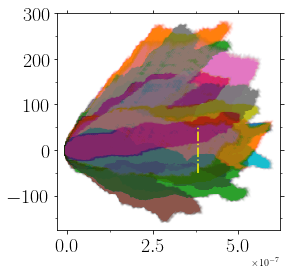

tmax= 3.82e-07


In [438]:
def main(temp_vac):
    nruns    = eval(confParser['Vacancy Dynamics']['nruns'])
    tmins=[]
    ax=utl.PltErr(None,None,Plot=False)
    for irun in range(nruns):
        tdata = temp_vac.data[irun][:,0]

        tmins.append(tdata.max())
        for idime in range(3):
            xdata = temp_vac.data[irun][:,idime+1]
        #
            utl.PltErr(tdata,xdata,
                      attrs={'fmt':'x','alpha':.01},
                       ax=ax,
                       Plot=False,
    #                    xscale='log',
    #                    yscale='log',
    #                    ylim=(1e0,1e2),
                      )
    tmax = np.min(tmins)
    yminmax=50
    utl.PltErr([tmax,tmax],[-yminmax,yminmax],
               attrs={'fmt':'-.','color':'yellow'},
               ax=ax,
              title='png/dx_dt.png'
              )
    print('tmax=',tmax)
    
main(temp_vac)

mkdir: png: File exists
single realizations


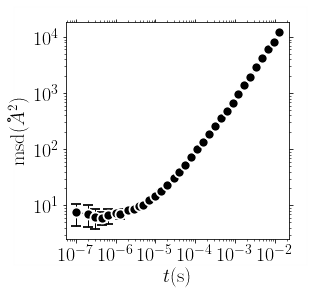

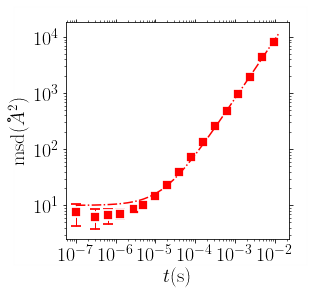

In [54]:
def main():
    if eval(confParser['flags']['RemoteMachine']):
        return
    !mkdir png
    #--- temp object
    temp = Temperature(
        ['size0_vac_ws'],[list(range(1))]*10,
#          verbose = True,
                     )
    #
    #--- parse data
    temp.Parse( list(map(lambda x:'vacancy/koreanPotential/%s/Run%s/png/msd.txt'%(x[0],x[1]),
                         temp.temps_runs ))
             )
    #
    #--- plot
#    xlim = (1e-11,0.8e-6)
    xlim = (1e-11,1e4)
#    ylim = (1e-1,1e3)
    print('single realizations')
    temp.Plot(**{
                  'xscale':'log',
                  'yscale':'log',
                   'attrs':{'fmt':'-'},
#                   'xlim':xlim,
#                      'ylim':ylim,
#                    'title':'png/msd_temp_ni.png',
                    'xstr':r'$t(\mathrm{s})$','ystr':r'$\mathrm{msd}(\r{A}^2)$',
        'bbox_to_anchor':(0.01,0.3,0.5,0.5)
    })
    
    temp.EnsAverage(
                   )
    #
    #--- fit
    #
    temp.Fit(Plot=True,
#              shift=True,
            p0=[[1e0, 1e10, 1.0]],
               sigma=True, #--- comment for ni
              xlo=xlim[0], xhi=xlim[1],
             plotAttrs={'yscale':'log',
                  'xscale':'log',
#                    'xlim':xlim,
#                       'ylim':ylim,
                        'ndecade_x':1,
                    'bbox_to_anchor':(-0.05,0.33,0.5,0.5),
                   'title':'png/msd_temp_ni_fit_inset.png',
                    'xstr':r'$t(\mathrm{s})$','ystr':r'$\mathrm{msd}(\r{A}^2)$',
#                         'fontsize':24,
                        'nevery':3,
                     'title':'png/alpha_temp_ni.png',
#              'halfopen':True
                       }
            )



#     temp.PlotExponent(**{
#                     'title':'png/alpha_temp_ni.png',
#                     'ylim':(0.5,1.5),
#                     }
#                 )
    
    return temp

temp = main()

In [43]:
temp.data_averaged['size0_vac']

array([[1.00000000e-07, 7.44548302e+00, 3.17476463e+00],
       [2.00000000e-07, 7.03495817e+00, 2.99971624e+00],
       [3.00000000e-07, 6.15044420e+00, 2.41240269e+00],
       [4.43928571e-07, 6.05247544e+00, 1.61759210e+00],
       [6.56400000e-07, 6.59270304e+00, 1.86469801e+00],
       [9.97788580e-07, 7.27211796e+00, 2.81894683e-01],
       [1.31964286e-06, 7.11317705e+00, 1.34426411e+00],
       [1.99391371e-06, 8.12973734e+00, 3.09606008e-01],
       [2.96542135e-06, 8.55254878e+00, 3.20520317e-01],
       [3.95745053e-06, 9.69751948e+00, 3.63302366e-01],
       [5.00904167e-06, 1.02120590e+01, 3.68495940e-01],
       [7.02267241e-06, 1.22228395e+01, 2.65213028e-01],
       [1.00087214e-05, 1.44741877e+01, 1.93454017e-01],
       [1.40295182e-05, 1.81727935e+01, 3.06738389e-01],
       [2.00098874e-05, 2.28301549e+01, 2.49008496e-01],
       [2.89825027e-05, 3.01763392e+01, 2.93437827e-01],
       [3.99870503e-05, 3.97234057e+01, 3.52370326e-01],
       [5.56992138e-05, 5.19560

In [44]:
temp.data_averaged['size0_vac_ws']

array([[1.00000000e-07, 7.45681803e+00, 3.17959789e+00],
       [2.00000000e-07, 7.04255388e+00, 3.00295506e+00],
       [3.00000000e-07, 6.15457339e+00, 2.41402230e+00],
       [4.43928571e-07, 6.05800564e+00, 1.61907011e+00],
       [6.56400000e-07, 6.59663203e+00, 1.86580930e+00],
       [9.97788580e-07, 7.27933976e+00, 2.82174628e-01],
       [1.31964286e-06, 7.11895574e+00, 1.34535618e+00],
       [1.99391371e-06, 8.13592849e+00, 3.09841786e-01],
       [2.96542135e-06, 8.55877771e+00, 3.20753756e-01],
       [3.95745053e-06, 9.70582962e+00, 3.63613692e-01],
       [5.00904167e-06, 1.02163107e+01, 3.68649357e-01],
       [7.02267241e-06, 1.22323434e+01, 2.65419245e-01],
       [1.00087214e-05, 1.44852454e+01, 1.93601808e-01],
       [1.40295182e-05, 1.81884872e+01, 3.07003283e-01],
       [2.00098874e-05, 2.28474752e+01, 2.49197408e-01],
       [2.89825027e-05, 3.02011922e+01, 2.93679501e-01],
       [3.99870503e-05, 3.97541735e+01, 3.52643255e-01],
       [5.56992138e-05, 5.19984

In [ ]:
if not eval(confParser['flags']['RemoteMachine']):
    symbols=utl.Symbols()
    legends = Legends()
    legends.Set(bbox_to_anchor=(0.1,0.5,0.5,0.5))
    #
    ax=utl.PltErr([0.5e-3,1e-3],[1,1],attrs={'fmt':'-.r'},Plot=False)
    utl.PltErr(1.0/np.array(temp.temps),
               list(map(lambda x:temp.exponent[x][0],temp.temps)),
               yerr=list(map(lambda x:1.0*(temp.exponent[x][1]-temp.exponent[x][2]),temp.temps)),
               attrs=symbols.GetAttrs(count=0,label=r'$\mathrm{Total}$'),
               ax=ax,
               Plot=False,
    #           **kwargs
              )

    utl.PltErr(1.0/np.array(temp_vac.temps),
               list(map(lambda x:temp_vac.exponent[x][0],temp_vac.temps)),
               yerr=list(map(lambda x:1.0*(temp_vac.exponent[x][1]-temp_vac.exponent[x][2]),temp_vac.temps)),
               attrs=symbols.GetAttrs(count=1,label=r'$\mathrm{Vacancy}$'),
               DrawFrame=DRAW_FRAME,
               ax=ax,
                       ylim=(.5,1.5),
#               halfopen=True,
#               legend=legends.Get(),
                        title='png/alpha_temp_cantor.png',
              )
